In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
# load the data 
df = pd.read_csv('Data/engines2_data_cleaned_no_outliers.csv')

In [3]:
# getdummy for eng_number
df = pd.get_dummies(df, columns=['flight_phase'], drop_first=True)

In [4]:
# Assume df is sorted by engine ID and flight_cycle
features = ['flight_cycle', 'egt_probe_average', 'fuel_flw', 'core_spd', 'zpn12p', 'vib_n1_#1_bearing', 'vib_n2_#1_bearing', 'vib_n2_turbine_frame']
target = 'RUL'
window_size = 30
# Scale features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
# Convert to sequences
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[features].iloc[i:i+window_size].values)
        y.append(data[target].iloc[i+window_size])
    return np.array(X), np.array(y)

# Example on one engine for now
engine_data = df[df['eng_number'] == df['eng_number'].unique()[0]].copy()
X, y = create_sequences(engine_data, window_size=window_size)

In [5]:
split_1 = int(0.8 * len(X))
split_2 = int(0.9 * len(X))

X_train, y_train = X[:split_1], y[:split_1]
X_val, y_val = X[split_1:split_2], y[split_1:split_2]
X_test, y_test = X[split_2:], y[split_2:]

In [6]:
# Build the Model

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, len(features))),  # Change input shape to match number of features
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal'),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

 # Print the model summary 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,919 (273.12 KB)

 Trainable params: 69,919 (273.12 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Get initial weights
init_weights = model.get_weights()

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

class LRFinder(Callback):
    def __init__(self, min_lr=1e-7, max_lr=1, steps=100):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.lrs = []
        self.losses = []
        self.step = 0

    def on_batch_end(self, batch, logs=None):
        lr = self.min_lr * (self.max_lr / self.min_lr) ** (self.step / self.steps)
        self.lrs.append(lr)
        self.losses.append(logs['loss'])
        self.step += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        if self.step >= self.steps:
            self.model.stop_training = True

lr_finder_model = tf.keras.models.clone_model(model)
lr_finder_model.compile(optimizer=tf.keras.optimizers.Adam(1e-7), loss='mse')

lr_finder_model.fit(X_train, y_train, batch_size=64, epochs=1, callbacks=[LRFinder()], verbose=0)

# Plot
plt.plot(np.log10(LRFinder().lrs), LRFinder().losses)
plt.xlabel("log10(Learning Rate)")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.grid(True)
plt.show()


ValueError: Argument `learning_rate` should be float, or an instance of LearningRateSchedule, or a callable (that takes in the current iteration value and returns the corresponding learning rate value). Received instead: learning_rate=<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0000000116860974e-07>

In [49]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',     # Can also be 'val_mae' or another metric
    patience=10,             # Waits 5 epochs without improvement before stopping
    restore_best_weights=True,  # Restore model from best epoch
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,               # Set a large value, early stop will handle the rest
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/100
163/163 [==============================] - 4s 22ms/step - loss: 1430.4702 - mae: 23.1014 - val_loss: 39934.7930 - val_mae: 175.9972
Epoch 2/100
163/163 [==============================] - 3s 21ms/step - loss: 140.0281 - mae: 9.2098 - val_loss: 38264.6797 - val_mae: 172.5226
Epoch 3/100
163/163 [==============================] - 3s 21ms/step - loss: 72.2694 - mae: 6.6653 - val_loss: 36103.6562 - val_mae: 166.6297
Epoch 4/100
163/163 [==============================] - 3s 21ms/step - loss: 38.6716 - mae: 4.8734 - val_loss: 34974.3594 - val_mae: 163.7923
Epoch 5/100
163/163 [==============================] - 4s 21ms/step - loss: 72.4491 - mae: 6.7687 - val_loss: 34907.0391 - val_mae: 162.7377
Epoch 6/100
163/163 [==============================] - 3s 21ms/step - loss: 142.9351 - mae: 8.8040 - val_loss: 37134.2109 - val_mae: 169.3329
Epoch 7/100
163/163 [==============================] - 4s 22ms/step - loss: 681.6894 - mae: 17.7917 - val_loss: 39738.9453 - val_mae: 175.5015
Epoch 

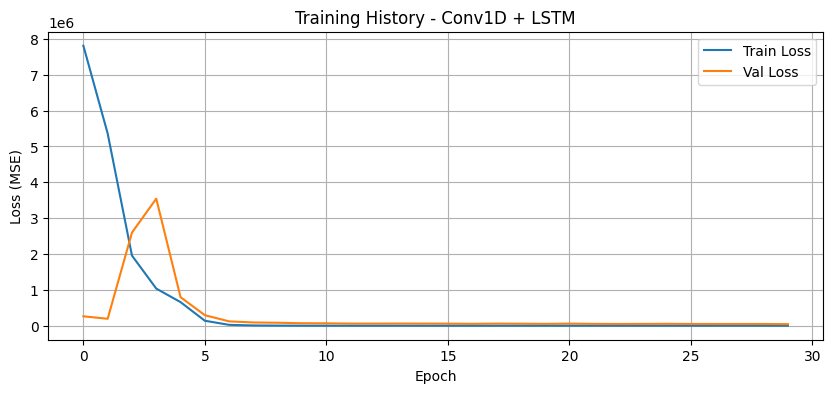

In [46]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training History - Conv1D + LSTM')
plt.legend()
plt.grid(True)
plt.show()
